In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

Read catalog with Gaia DR2 data for the SDSS Stripe 82 region, see

https://github.com/dirac-institute/ivezic/blob/master/GaiaSprintUW2018/getStripe82fromGaiaDR2.ipynb


In [2]:
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
gaia = Table.read('Stripe82_GaiaDR2.dat', format='ascii', names=colnames)
# developed code using Stripe82_GaiaDR2_1percent.dat
# a 1% subsample produced with
# cat Stripe82_GaiaDR2.dat | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}' > Stripe82_GaiaDR2_1percent.dat
# gaia = Table.read('Stripe82_GaiaDR2_1percent.dat', format='ascii', names=colnames)

Read SDSS Stripe82 Standard Star Catalog, see
http://faculty.washington.edu/ivezic/sdss/catalogs/stripe82.html

In [3]:
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

sdss = Table.read('stripe82calibStars_v2.6.dat', format='ascii', names=colnames)

Match Gaia to SDSS, since here SDSS is much larger 

In [4]:
sdss_coords = SkyCoord(ra = sdss['ra']*u.degree, dec= sdss['dec']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['ra']*u.degree, dec= gaia['dec']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idx, d2d, d3d = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idx]], table_names = ['gaia', 'sdss'])
gaia_sdss['sep_2d_arcsec'] = d2d.arcsec

# since it's matching gaia to sdss,
# the resulting catalog has the same length 
# as gaia ... 

Select good matches

In [5]:
# gaia sources that have a good (within 0.5 arcsec) sdss match 
flag = (gaia_sdss['sep_2d_arcsec'] < 0.5)   
gaia_matched = gaia_sdss[flag]
print(len(gaia_sdss))
print(len(gaia_matched))

2397440
894449


In [6]:
rMed = gaia_matched['r_mMed'] 
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed'] 
ra = gaia_matched['ra_gaia']
raW = np.where(ra > 180, ra-360, ra)   
flagOK = ((raW > -60) & (raW < 60) & (rMed>16) & (rMed<19) & (gi>0.5) & (gi<2.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

225711


In [21]:
# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(data, theta, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(data, degree, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(data, theta, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

In [11]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [137]:
rMedOK = gaia_matchedOK['r_mMed'] 
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed'] 
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed']
raOK = gaia_matchedOK['ra_gaia']
raWok = np.where(raOK > 180, raOK-360, raOK)   
decOK = gaia_matchedOK['dec_gaia']
theta3best = [0.0644284 , -0.16440366,  0.25599561, -0.09994182]
GrModel = sum(t * giOK ** n for (n, t) in enumerate(theta3best))
GrResid = GrOK - GrModel + 0.011    # 0.011 correction for 16<r<18 range
xBin, nPts, medianBin, sigGbin = fitMedians(giOK, GrResid, 0.5, 2.0, 30, 1)
xBin2, nPts2, medianBin2, sigGbin2 = fitMedians(giOK[rMed<18], GrResid[rMed<18], 0.5, 2.0, 30, 1)

median: 0.00277681284057
median: 0.000966688541631


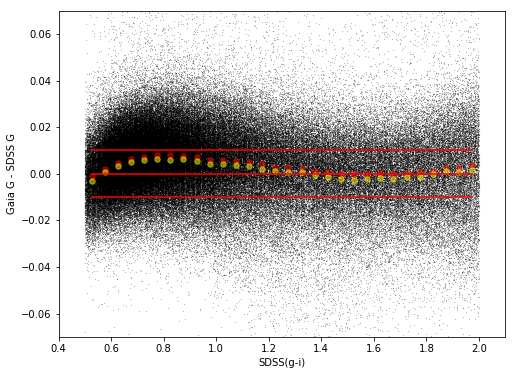

In [138]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(giOK, GrResid, s=0.01, c='black')
ax.set_xlim(0.4,2.1)
ax.set_ylim(-0.07,0.07)
ax.set_xlabel('SDSS(g-i)')
ax.set_ylabel('Gaia G - SDSS G')
# medians
ax.scatter(xBin, medianBin, s=30.0, c='red', alpha=0.5, label='medians all')
ax.scatter(xBin2, medianBin2, s=30.0, c='yellow', alpha=0.5, label='medians best')
ax.plot(xBin, 0*xBin+0.00, c='red')
ax.plot(xBin, 0*xBin+0.01, c='red')
ax.plot(xBin, 0*xBin-0.01, c='red')

In [139]:
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(rMedOK, GrResid, 16, 19, 60, 0)

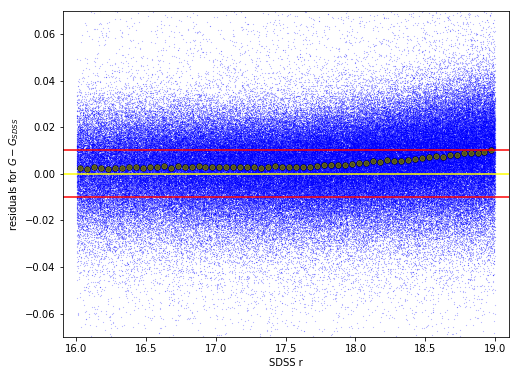

In [140]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(rMedOK, GrResid, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
ax.set_xlim(15.9,19.1)
ax.set_ylim(-0.07,0.07)
ax.set_xlabel('SDSS r')
ax.set_ylabel('residuals for $G-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [141]:
print(medianBinMg)

[ 0.00231442  0.00186623  0.00283067  0.0024693   0.00195485  0.00256393
  0.00235357  0.00281015  0.00269408  0.00232612  0.00289572  0.00301226
  0.00335651  0.00251379  0.00322156  0.00299802  0.002699    0.00319168
  0.00276975  0.00297681  0.00290589  0.00282037  0.00291179  0.00298905
  0.00274435  0.00295396  0.00266269  0.00275157  0.0035003   0.00281419
  0.00273191  0.00309688  0.00306497  0.00274635  0.00352116  0.00359208
  0.00364254  0.00372586  0.00389566  0.00433318  0.00446289  0.00475546
  0.0055163   0.00496431  0.00583212  0.00558019  0.00555308  0.00602661
  0.00648647  0.00680522  0.00733941  0.00743581  0.00719968  0.00798333
  0.00813902  0.00881715  0.0087805   0.00898821  0.00929689  0.01008688]


In [142]:
np.median(GrResid)
GrResid = GrResid - np.median(GrResid)

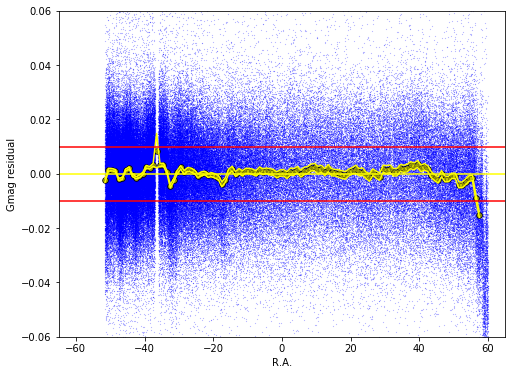

In [143]:
ra = gaia_matchedOK['ra_sdss'] 
raW = np.where(ra > 180, ra-360, ra)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raWok, GrResid, s=0.01, c='blue')
ax.set_xlim(-65,65)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('R.A.')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(raW, GrResid, -52, 58, 110, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [144]:
print(np.median(medianBin))
print(np.std(medianBin))
print(np.min(medianBin))
print(np.max(medianBin))

0.000549686909463
0.00249852241444
-0.0150327247949
0.00847234340172


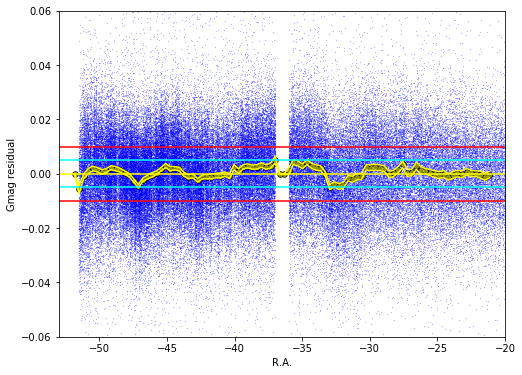

In [145]:
ra = gaia_matchedOK['ra_sdss'] 
raW = np.where(ra > 180, ra-360, ra)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raWok, GrResid, s=0.01, c='blue')
ax.set_xlim(-53,-20)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('R.A.')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(raW, GrResid, -52, -21, 92, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
ax.plot(xL, 0*xL+0.005, c='cyan')
ax.plot(xL, 0*xL-0.005, c='cyan')



In [161]:
def correctZeropoint(X, Z, thetaAll):
    xLeft = -1.3
    for i in range(0,12):
        xRight = -1.2655 + (i+1)*0.2109
        theta = thetaAll[i]
        xB = X[(X>xLeft)&(X<xRight)]
        zB = Z[(X>xLeft)&(X<xRight)]
        Zfit = polynomial_fit(theta, xB)
        xLeft = xRight
        if (i==0):
            Xcorr = xB
            Zcorr = zB - Zfit
        else: 
            Xcorr = np.concatenate((Xcorr, xB), axis=0)
            Zcorr = np.concatenate((Zcorr, zB-Zfit), axis=0)
            
    return Xcorr, Zcorr 

In [147]:
dS = decOK
rS = GrResid

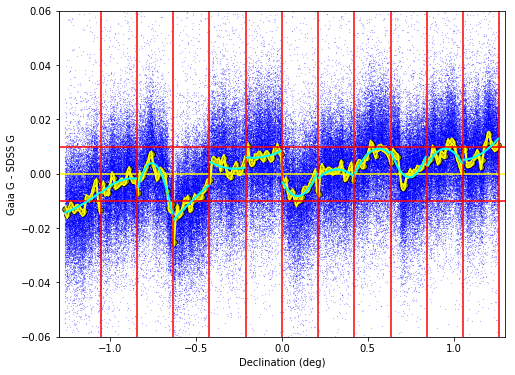

In [162]:
decOK = dS[raWok<50]
GrResid = rS[raWok<50]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decOK, GrResid, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Gaia G - SDSS G')
xBin, nPts, medianBin, sigGbin = fitMedians(decOK, GrResid, -1.266, 1.264, 252, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
dCleft = -1.3
ax.plot(0*xL+dCleft, xL, c='red')
alltheta = []
for i in range(0,12):
    decCol = -1.2655 + (i+1)*0.2109
    ax.plot(0*xL+decCol, xL, c='red')
    xR = xBin[(xBin>dCleft)&(xBin<decCol)]
    yR = medianBin[(xBin>dCleft)&(xBin<decCol)]
    dyR = sigGbin[(xBin>dCleft)&(xBin<decCol)]
    data = np.array([xR, yR, dyR])
    theta2 = best_theta(data,2)
    alltheta.append(theta2)
    yfit = polynomial_fit(theta2, xR)
    ax.plot(xR, yfit, c='cyan', lw=2)
    dCleft = decCol
    rrr = yR - yfit
    # print(i, np.median(rrr), np.std(rrr))  # 2 milimag scatter 
    # print(i, theta2)
    
# finish this code... 
decCorr, GrResidCorr = correctZeropoint(decOK, GrResid, alltheta)

In [149]:
print(np.median(medianBin))
print(np.std(medianBin))
print(np.min(medianBin))
print(np.max(medianBin))

0.00105392038866
0.00723864192843
-0.0251340079626
0.014570404699


In [163]:
alltheta

[array([ 0.10620684,  0.16564862,  0.05558282]),
 array([-0.11955563, -0.27127772, -0.1561399 ]),
 array([-0.74928556, -1.98926209, -1.31345944]),
 array([ 0.01081601,  0.01750717, -0.04230308]),
 array([ 0.0103487 ,  0.06262293,  0.11528357]),
 array([ 0.00854732,  0.03148502,  0.09264025]),
 array([-0.00273196, -0.11891232,  0.64595556]),
 array([-0.02592111,  0.17100888, -0.26601152]),
 array([-0.13749387,  0.51926554, -0.45944799]),
 array([ 0.46288597, -1.25034366,  0.84189109]),
 array([-0.49611885,  1.06216637, -0.55816643]),
 array([ 0.18458747, -0.34454179,  0.16530951])]

0 6.69757816525e-05 0.00235904026282
1 -0.00058751557866 0.00166711914676
2 -0.000223648071469 0.00227050255073
3 0.000256604960669 0.00183660694323
4 0.000227994594156 0.00164490914939
5 0.000352812567954 0.0014389831488
6 2.36038698702e-05 0.00164241244533
7 -9.21576241189e-05 0.00204841887107
8 -1.04102896561e-05 0.00130525988581
9 0.000152039844761 0.0023948379594
10 -0.000130355835335 0.00183135853164
11 -6.40053671462e-05 0.00211135667353


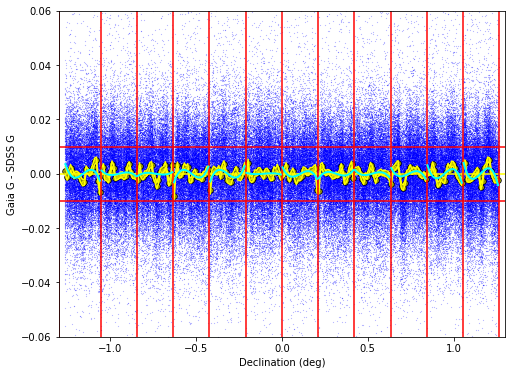

In [165]:
decOK = decCorr
GrResid = GrResidCorr
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decOK, GrResid, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Gaia G - SDSS G')
xBin, nPts, medianBin, sigGbin = fitMedians(decOK, GrResid, -1.266, 1.264, 252, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
dCleft = -1.3
ax.plot(0*xL+dCleft, xL, c='red')
for i in range(0,12):
    decCol = -1.2655 + (i+1)*0.2109
    ax.plot(0*xL+decCol, xL, c='red')
    xR = xBin[(xBin>dCleft)&(xBin<decCol)]
    yR = medianBin[(xBin>dCleft)&(xBin<decCol)]
    dyR = sigGbin[(xBin>dCleft)&(xBin<decCol)]
    data = np.array([xR, yR, dyR])
    theta2 = best_theta(data,3)
    yfit = polynomial_fit(theta2, xR)
    ax.plot(xR, yfit, c='cyan', lw=2)
    dCleft = decCol
    rrr = yR - yfit
    print(i, np.median(rrr), np.std(rrr))  # 2 milimag scatter 
    # print(i, theta2)
    

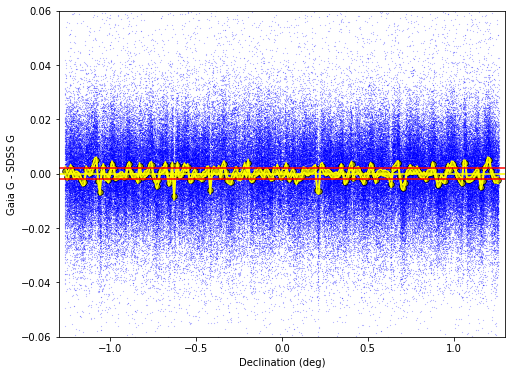

In [173]:
decOK = decCorr
GrResid = GrResidCorr
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decOK, GrResid, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Gaia G - SDSS G')
xBin, nPts, medianBin, sigGbin = fitMedians(decOK, GrResid, -1.266, 1.264, 252, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.002, c='red')
ax.plot(xL, 0*xL-0.002, c='red')

In [172]:
np.std(medianBin)

0.0011540227600640468

In [175]:
np.max(np.abs(medianBin))

0.0083152091547570618

In [178]:
aa= ([ 0.10620684,  0.16564862,  0.05558282],
     [-0.11955563, -0.27127772, -0.1561399 ],
     [-0.74928556, -1.98926209, -1.31345944],
     [ 0.01081601,  0.01750717, -0.04230308],
     [ 0.0103487 ,  0.06262293,  0.11528357],
     [ 0.00854732,  0.03148502,  0.09264025],
     [-0.00273196, -0.11891232,  0.64595556],
     [-0.02592111,  0.17100888, -0.26601152],
     [-0.13749387,  0.51926554, -0.45944799],
     [ 0.46288597, -1.25034366,  0.84189109],
     [-0.49611885,  1.06216637, -0.55816643],
     [ 0.18458747, -0.34454179,  0.16530951]) 

In [179]:
decOK = dS[raWok<50]
GrResid = rS[raWok<50]
decCorr, GrResidCorr = correctZeropoint(decOK, GrResid, aa)

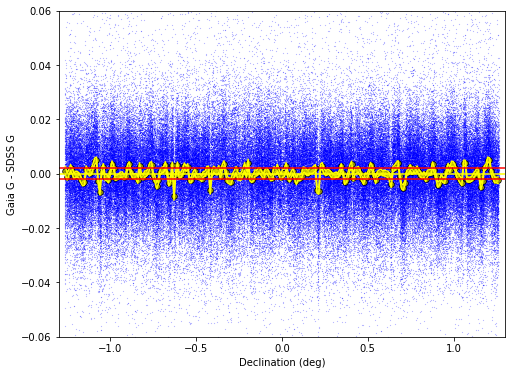

In [180]:
decOK = decCorr
GrResid = GrResidCorr
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decOK, GrResid, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Gaia G - SDSS G')
xBin, nPts, medianBin, sigGbin = fitMedians(decOK, GrResid, -1.266, 1.264, 252, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.002, c='red')
ax.plot(xL, 0*xL-0.002, c='red')